# Лабораторная работа 2, Ковригина Софья, Б20-505

### Харакетеристики системы

```bash
machdep.cpu.brand_string: Apple M1
machdep.cpu.core_count: 8
machdep.cpu.cores_per_package: 8
machdep.cpu.logical_per_package: 8
machdep.cpu.thread_count: 8
```

In [1]:
CORE_LIMIT = 16
ELEMENT_TRIM = 100

import pandas as pd
import seaborn as sns

In [5]:
arr = []

with open("trace.txt", "r") as fd:
    for i in range(CORE_LIMIT):
        line = list(map(float, fd.readline().split(";")))
        line = sorted(line)[ELEMENT_TRIM:-ELEMENT_TRIM]
        avg_value = (sum(line) / len(line))
        arr.append(avg_value)

In [6]:
# Create DataFrames
cur_data = [[index+1, avg_time, "Calculated"] for index, avg_time in enumerate(arr)]
perf_data = cur_data.copy()
for i in range(1, len(perf_data)): 
    perf_data[i] = [perf_data[i][0], perf_data[0][1] / perf_data[i][0], "Perfect"]
perf_data[0] = [perf_data[0][0], perf_data[0][1], "Perfect"] 

curr_df = pd.DataFrame(cur_data, columns=["Threads", "Time", "Type"])
perf_df = pd.DataFrame(perf_data, columns=["Threads", "Time", "Type"])

all_df = pd.concat([curr_df, perf_df])

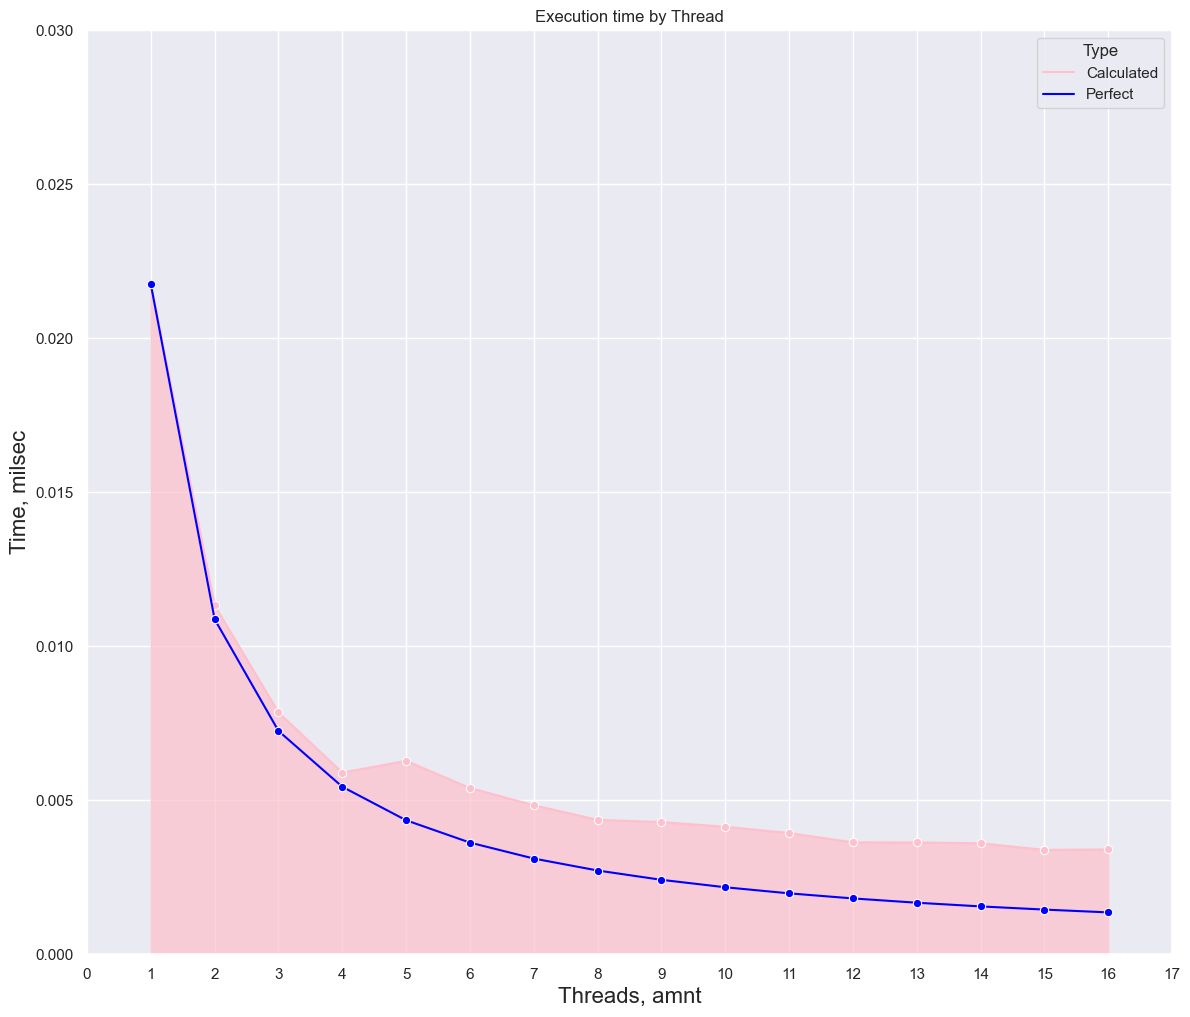

In [11]:
# Time graph
p = sns.lineplot(x="Threads", y="Time", hue="Type", palette=["pink", "blue"],marker="o", data=all_df)
p.set_xlabel("Threads, amnt", fontsize = 16)
p.set_ylabel("Time, milsec", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
_ = p.fill_between(x1, y1, color="pink", alpha=0.7)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])
_ = p.set_yticks([val*0.005 for val in range(7)])
sns.set(rc={'figure.figsize':(12,10)})
_ = p.set(title='Execution time by Thread')

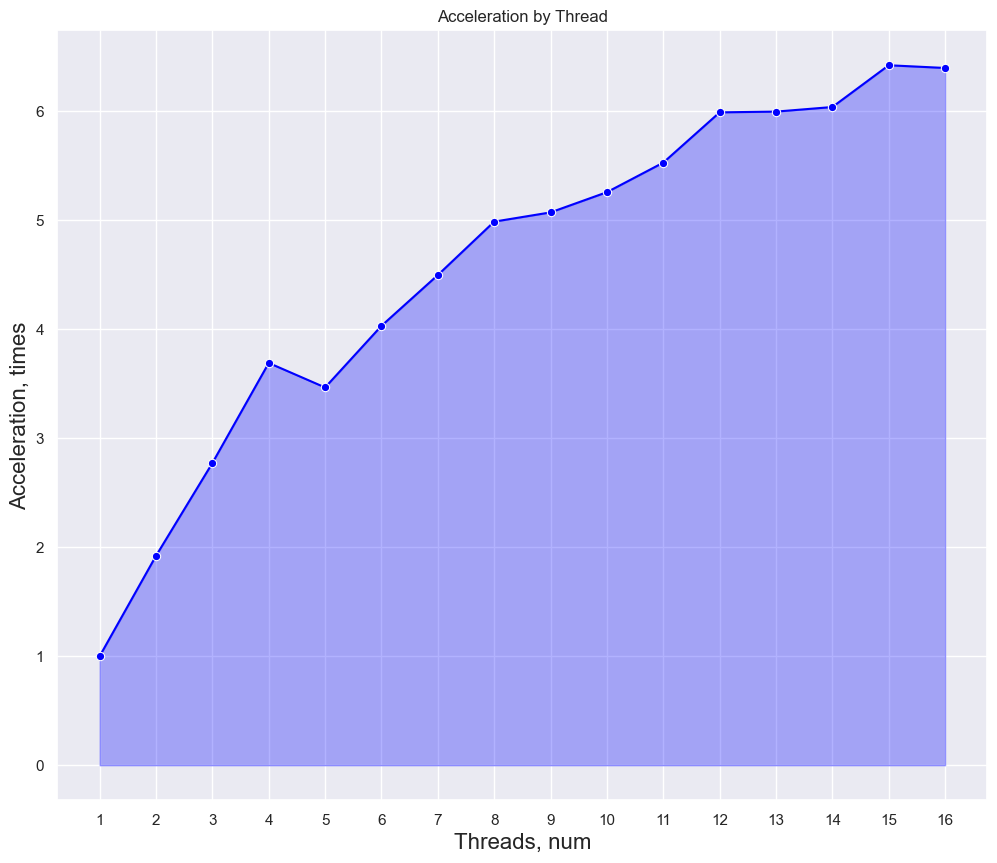

In [8]:
# Acceleration per thread
acceleration = [0] * CORE_LIMIT
for i in range(CORE_LIMIT):
    acceleration[i] = [cur_data[i][0], cur_data[0][1] / cur_data[i][1]]
acc_df = pd.DataFrame(acceleration, columns=["Threads", "Acceleration"])
p = sns.lineplot(x="Threads", y="Acceleration", marker="o", data=acc_df, color='blue')

p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("Acceleration, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])

_ = p.fill_between(x1, y1, color="blue", alpha=0.3)
_ = p.set(title='Acceleration by Thread')

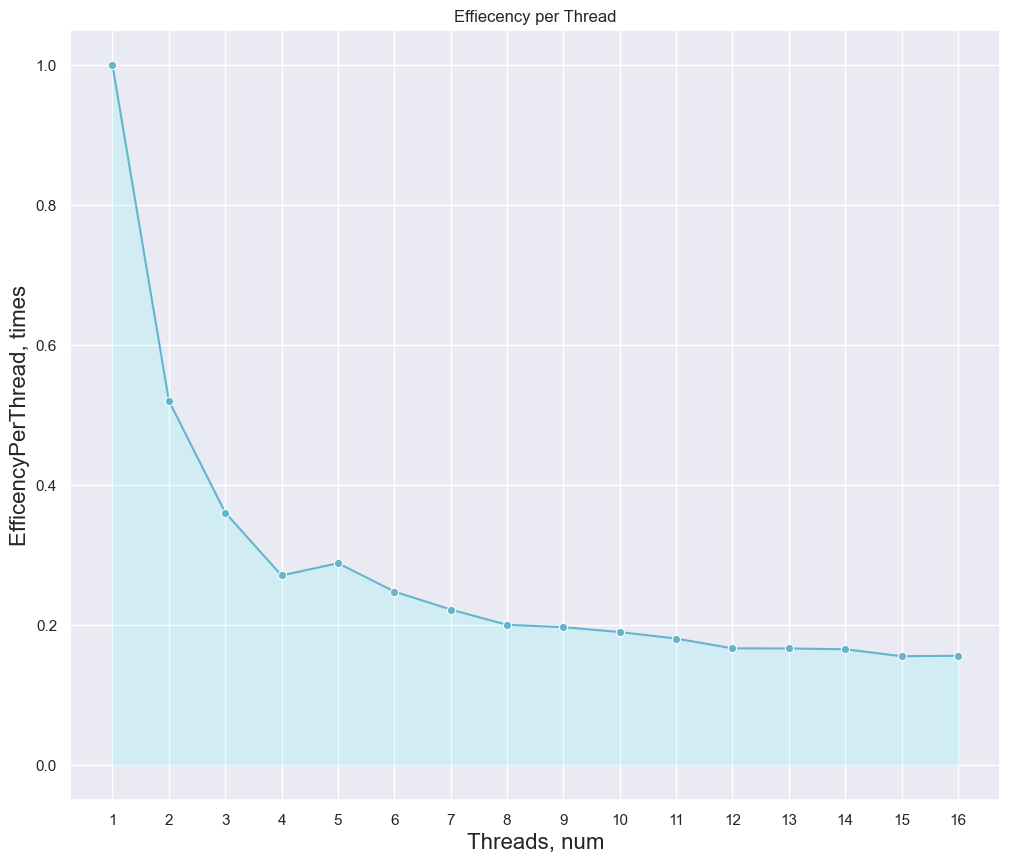

In [9]:
# Effiecency
effiecency = [0] * CORE_LIMIT
for i in range(CORE_LIMIT):
    effiecency[i] = [acceleration[i][0], acceleration[0][1] / acceleration[i][1]]


eff_df = pd.DataFrame(effiecency, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=eff_df, color='c')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.set(title='Effiecency per Thread')

## Заключение

В данной работе я ознакомилась с работой с параллельными циклами и способами остановки параллельного сегмента. 
- Создание дополнительных потоков для выполнения программы может привести как к ускорению, так и к замедлению работы программыю
- Использование всех доступных потоков системы может привести к негативным последствиям, так как часть из них может быть зарезервирована под фоновые процессы (к примеру Telegramm или Discord)

### Код программы 

``` C
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define STEP 10000
#define CORE_LIMIT 16

int main(int argc, char** argv)
{
    const int count = 10000000;     ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed
    // const int target = 16;          ///< Number to look for

    int* array = 0;                 ///< The array we need to find the max in
    int  index = -1;                ///< The index of the element we need

    /* Initialize the RNG */
    srand(random_seed);
    double start, end;

    /* Generate the random array */
    array = (int*)malloc(count*sizeof(int));
    for(int i=0; i<count; i++) { array[i] = rand(); }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }

    for (int thread = 1; thread <= CORE_LIMIT; thread++) {
        printf("\nRunning in %d threads\n", thread);

        for (int ind = 0; ind < count; ind += STEP) {
            int target = array[ind];
            int ans = -1;
            int tmp = count;
            start = omp_get_wtime();
            #pragma omp parallel num_threads(thread) shared(array, tmp, target) reduction(max: ans) default(none)
            {
                #pragma omp for
                for(int i=0; i<tmp; i++)
                {
                    if(array[i] == target) { 
                        ans = i;
                        tmp = 0;
                    };
                }
            }
            end = omp_get_wtime();
            if (ind != count - STEP) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
        }
        printf(".");
    }
    fclose(fp);
    printf("Shutting down...\n");
    return(0);
}
```